Imports

In [6]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import mysql.connector
from sqlalchemy import create_engine

from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import AdaBoostRegressor
from sklearn.svm import SVR
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.model_selection import RandomizedSearchCV
from catboost import CatBoostRegressor
from xgboost import XGBRegressor

Importing Data

In [7]:
db_config = {
    'user': 'root',
    'password': 'qwerty123',
    'host': 'localhost',
    'database': 'med_cost'
}

conn = mysql.connector.connect(**db_config)

connection_string = f"mysql+mysqlconnector://{db_config['user']}:{db_config['password']}@{db_config['host']}/{db_config['database']}"
engine = create_engine(connection_string)

query = "SELECT * FROM insurance"

df = pd.read_sql(query, engine)

In [8]:
df.head()

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.90
1,18,male,33.770,1,no,southeast,1725.55
2,28,male,33.000,3,no,southeast,4449.46
3,33,male,22.705,0,no,northwest,21984.50
4,32,male,28.880,0,no,northwest,3866.86


In [9]:
df = df.drop_duplicates()

In [10]:
object_columns = df.select_dtypes(include='object')

for col in object_columns.columns:
    print('Feature: ', col, '\t', 'Unique Values: ', object_columns[col].unique())

Feature:  sex 	 Unique Values:  ['female' 'male']
Feature:  smoker 	 Unique Values:  ['yes' 'no']
Feature:  region 	 Unique Values:  ['southwest' 'southeast' 'northwest' 'northeast']


Variables

In [11]:
X = df.drop(columns=['charges'], axis=1)
X

,age,sex,bmi,children,smoker,region
0,19,female,27.900,0,yes,southwest
1,18,male,33.770,1,no,southeast
2,28,male,33.000,3,no,southeast
3,33,male,22.705,0,no,northwest
4,32,male,28.880,0,no,northwest
...,...,...,...,...,...,...
1333,50,male,30.970,3,no,northwest
1334,18,female,31.920,0,no,northeast
1335,18,female,36.850,0,no,southeast
1336,21,female,25.800,0,no,southwest


In [12]:
y = df['charges']
y

0       16884.90
1        1725.55
2        4449.46
3       21984.50
4        3866.86
          ...   
1333    10600.50
1334     2205.98
1335     1629.83
1336     2007.94
1337    29141.40
Name: charges, Length: 1337, dtype: float64

Preprocessing

In [15]:
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer

In [16]:
num_features = X.select_dtypes(exclude='object').columns
cat_features = X.select_dtypes(include='object').columns

In [17]:
numeric_transformer = StandardScaler()
cat_transformer = OneHotEncoder()

preprocessor = ColumnTransformer(
    [
        ('OneHotEncoder', cat_transformer, cat_features),
        ('StandardScaler', numeric_transformer, num_features)
    ]
)

In [19]:
X = preprocessor.fit_transform(X)

Preparing Train and Test Data

In [26]:
from sklearn.model_selection import train_test_split

In [27]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

Evaluate Function

In [28]:
def evaluate_model(true, predicted):
    mae = mean_absolute_error(true, predicted)
    mse = mean_squared_error(true, predicted)
    rmse = np.sqrt(mse)
    r2 = r2_score(true, predicted)
    return mae, rmse, r2

In [34]:
models = {
    "Linear Regression": LinearRegression(),
    "Lasso": Lasso(),
    "Ridge": Ridge(),
    "K-Neighbors Regressor": KNeighborsRegressor(),
    "Decision Tree": DecisionTreeRegressor(),
    "XGBRegressor": XGBRegressor(), 
    "CatBoost Regressor": CatBoostRegressor(verbose=False),
    "AdaBoost Regressor": AdaBoostRegressor()
}

In [35]:
model_list = []
r2_list = []

for i in range(len(list(models))):
    model = list(models.values())[i]
    model.fit(X_train, y_train) 

   
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)

    
    model_train_mae , model_train_rmse, model_train_r2 = evaluate_model(y_train, y_train_pred)
    model_test_mae , model_test_rmse, model_test_r2 = evaluate_model(y_test, y_test_pred)

    
    print(list(models.keys())[i])
    model_list.append(list(models.keys())[i])
    
    print('Model performance for Training Set')
    print("- Root Mean Squared Error: {:.4f}".format(model_train_rmse))
    print("- Mean Absolute Error: {:.4f}".format(model_train_mae))
    print("- R2 Score: {:.4f}".format(model_train_r2))

    print('----------------------------------')
    
    print('Model performance for Test Set')
    print("- Root Mean Squared Error: {:.4f}".format(model_test_rmse))
    print("- Mean Absolute Error: {:.4f}".format(model_test_mae))
    print("- R2 Score: {:.4f}".format(model_test_r2))
    r2_list.append(model_test_r2)
    
    print('='*35)
    print('\n')

Linear Regression
Model performance for Training Set
- Root Mean Squared Error: 6053.7190
- Mean Absolute Error: 4159.4927
- R2 Score: 0.7617
----------------------------------
Model performance for Test Set
- Root Mean Squared Error: 6056.9490
- Mean Absolute Error: 4253.9552
- R2 Score: 0.6846


Lasso
Model performance for Training Set
- Root Mean Squared Error: 6052.4605
- Mean Absolute Error: 4167.5491
- R2 Score: 0.7618
----------------------------------
Model performance for Test Set
- Root Mean Squared Error: 6053.9113
- Mean Absolute Error: 4258.4134
- R2 Score: 0.6849


Ridge
Model performance for Training Set
- Root Mean Squared Error: 6052.5259
- Mean Absolute Error: 4173.1842
- R2 Score: 0.7618
----------------------------------
Model performance for Test Set
- Root Mean Squared Error: 6049.4764
- Mean Absolute Error: 4260.0610
- R2 Score: 0.6854


K-Neighbors Regressor
Model performance for Training Set
- Root Mean Squared Error: 4639.2658
- Mean Absolute Error: 2824.3734


Results

In [36]:
pd.DataFrame(list(zip(model_list, r2_list)), columns=['Model Name', 'R2_Score']).sort_values(by=["R2_Score"],ascending=False)

,Model Name,R2_Score
6,CatBoost Regressor,0.843665
5,XGBRegressor,0.785932
7,AdaBoost Regressor,0.735118
3,K-Neighbors Regressor,0.716025
2,Ridge,0.685353
1,Lasso,0.684891
0,Linear Regression,0.684575
4,Decision Tree,0.651853


CatBoost Regressor

In [38]:
cat_model = CatBoostRegressor()
cat_model = cat_model.fit(X_train, y_train)
y_pred = cat_model.predict(X_test)
score = r2_score(y_test, y_pred)*100
print(" Accuracy of the model is %.2f" %score)

Learning rate set to 0.041377
0:	learn: 12030.1690231	total: 1.02ms	remaining: 1.02s
1:	learn: 11648.4723001	total: 1.55ms	remaining: 772ms
2:	learn: 11300.2420130	total: 2.57ms	remaining: 855ms
3:	learn: 10947.8779954	total: 3.66ms	remaining: 911ms
4:	learn: 10641.8443907	total: 5.21ms	remaining: 1.04s
5:	learn: 10338.0802120	total: 6.64ms	remaining: 1.1s
6:	learn: 10031.4311652	total: 7.72ms	remaining: 1.09s
7:	learn: 9746.6065563	total: 8.89ms	remaining: 1.1s
8:	learn: 9489.4916245	total: 9.85ms	remaining: 1.08s
9:	learn: 9240.4652987	total: 10.3ms	remaining: 1.02s
10:	learn: 8991.5838862	total: 11.3ms	remaining: 1.02s
11:	learn: 8766.9790592	total: 12.3ms	remaining: 1.01s
12:	learn: 8554.0316000	total: 13.5ms	remaining: 1.02s
13:	learn: 8370.9515299	total: 14.5ms	remaining: 1.02s
14:	learn: 8175.1246126	total: 15.4ms	remaining: 1.01s
15:	learn: 7978.5522507	total: 16.5ms	remaining: 1.01s
16:	learn: 7800.0831476	total: 17.5ms	remaining: 1.01s
17:	learn: 7630.0137659	total: 18.6ms	re

Text(0, 0.5, 'Predicted')

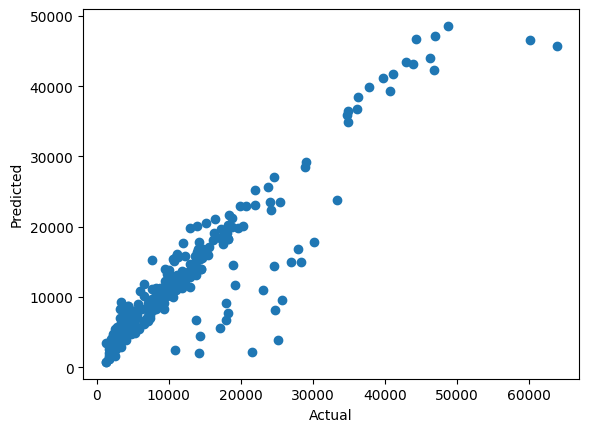

In [39]:
plt.scatter(y_test,y_pred)
plt.xlabel('Actual')
plt.ylabel('Predicted')

<Axes: xlabel='charges'>

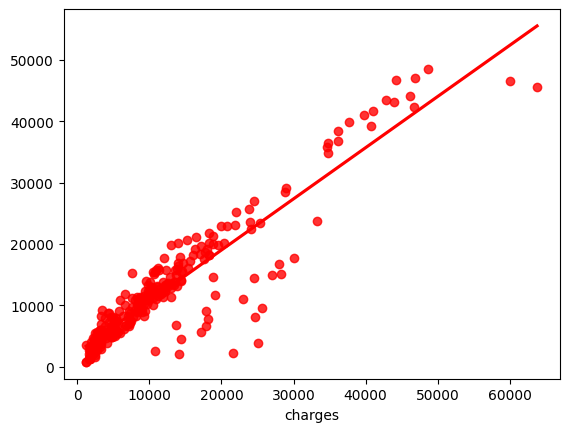

In [40]:
sns.regplot(x=y_test,y=y_pred,ci=None,color ='red')